## Face and Facial Keypoint detection

After we've trained a neural network to detect facial keypoints, we can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, we'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that the net expects. This step will be similar to the `data_transform` we've created and applied in Notebook 2, whose job was to rescale, normalize, and turn any image into a Tensor to be accepted as input to the CNN.
3. Use the trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

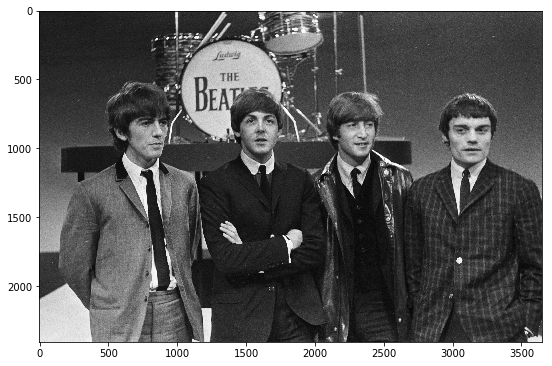

In [7]:
import cv2
from data_load import Rescale, RandomCrop, Normalize, ToTensor
# load in color image for face detection
image = cv2.imread('images/the_beatles.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, we'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


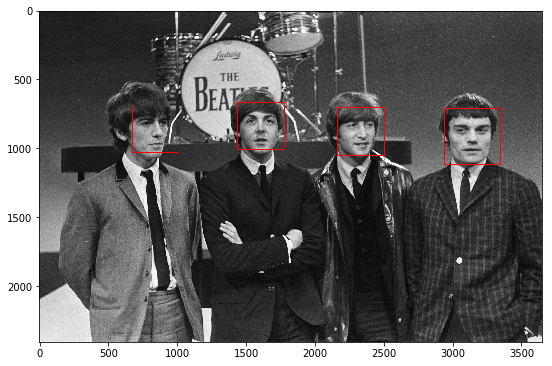

In [8]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.1, 10)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once we have an image to work with (and, again, we can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into the CNN facial keypoint detector.

First, load our best model by its filename.

In [9]:
import torch
from models import Net

net = Net()

# checking if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    net.cuda()
# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
## Load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/final_model.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

cuda:0


Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc1_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, t

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, we'll transform those faces in Tensors that our CNN can accept as input images.

### Transform each detected face into an input Tensor

we'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Note**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for the network to see as input, you can apply the `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. We should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [10]:
def show_all_keypoints(image, predicted_key_pts):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=80, marker='.', c='m')


# visualize the output
def visualize_output(test_images, test_outputs, batch_size=1):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)
        
        # un-transform the image data|
        image = test_images[i].data   # get the image from it's Variable wrapper
        if torch.cuda.is_available():
            image = image.data.cpu().numpy()
        else:
            image = image.numpy()   # convert to numpy array from a Tensor

        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data

        # convert to numpy array from a Tensor 
        if torch.cuda.is_available():
            predicted_key_pts = predicted_key_pts.data.cpu().numpy()
        else:
            predicted_key_pts = predicted_key_pts.numpy()   
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts)
            
        plt.axis('off')

    plt.show()
    



torch.Size([1, 1, 224, 224])


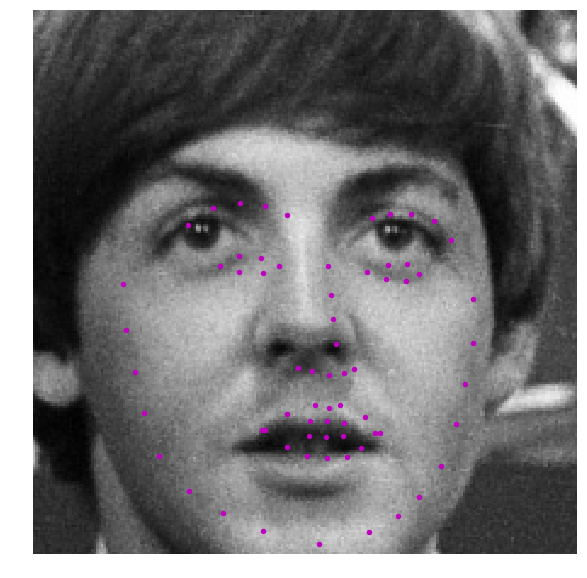

torch.Size([1, 1, 224, 224])


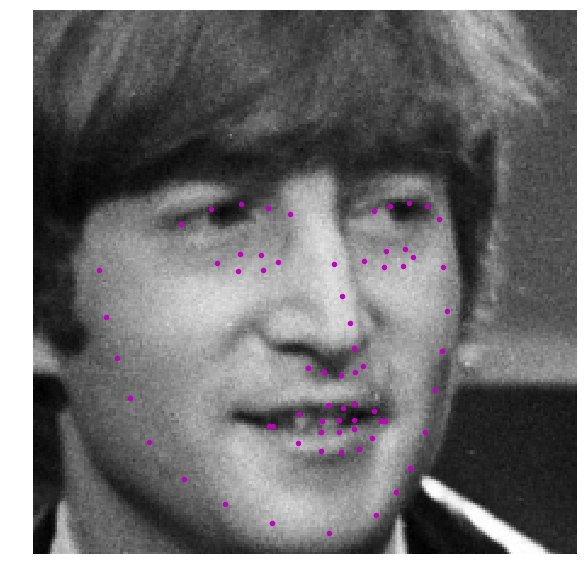

torch.Size([1, 1, 224, 224])


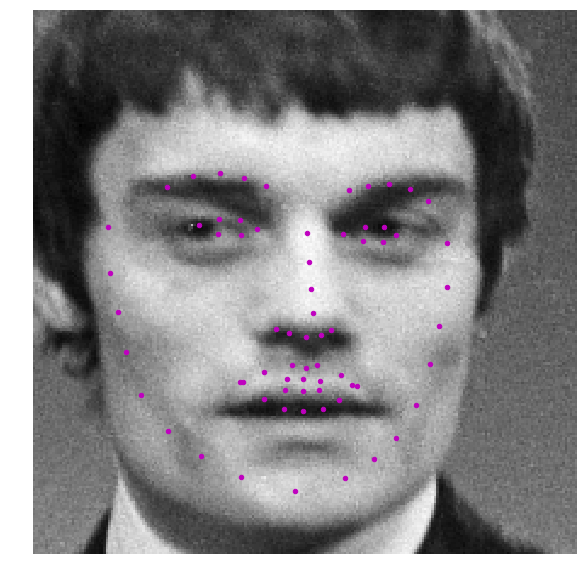

torch.Size([1, 1, 224, 224])


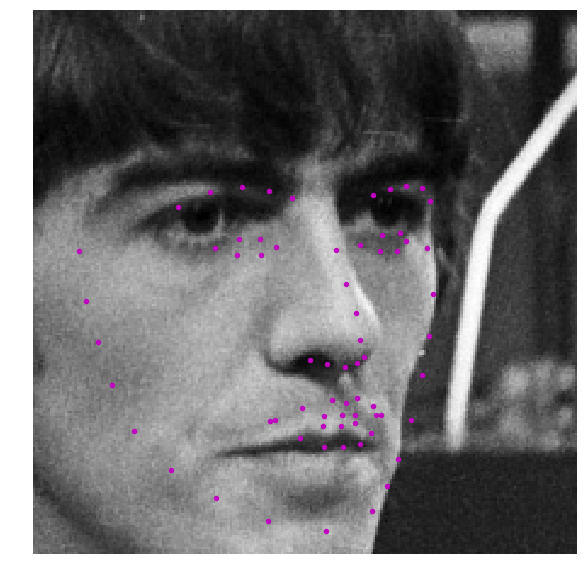

In [11]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    d = 10 # you could need to change this value
    roi = image_copy[y-d:y+h+d, x-d:x+w+d]
    
    ## Convert the face region from RGB to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    gray=  gray/255.0
    ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    img = cv2.resize(gray, (224,224))
    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    if(len(img.shape) == 2):
        # add that third color dim
        img = img.reshape(img.shape[0], img.shape[1], 1)
    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    img = img.transpose((2, 0, 1))
    torch_image = torch.from_numpy(img)
    # convert variables to floats for regression loss
    if torch.cuda.is_available():
        torch_image = torch_image.to(device=device, dtype=torch.float).unsqueeze(0)
    else:
        torch_image = torch_image.type(torch.FloatTensor).unsqueeze(0)

    print(torch_image.shape)
    ## Make facial keypoint predictions using your loaded, trained network 
    # forward pass to get net output
    output_pts = net(torch_image)
    # reshape to batch_size x 68 x 2 pts
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    
    ## Display each detected face and the corresponding keypoints        
    visualize_output(torch_image, output_pts)

